In [33]:
import pandas as pd
pd.set_option('display.max_columns', 100)

import numpy as np

from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

In [34]:
aita = pd.read_pickle('processed_aita.pickle')
aita = aita.sample(frac=1).reset_index(drop=True)
aita.shape

(18554, 38)

In [35]:
# need to remove reddit post common words.. these are not part of the story but a function of posting on reddit
aita['proc_text'] = [x.replace('x200b', '') for x in aita['proc_text']]
aita['proc_text'] = [x.replace('edit', '') for x in aita['proc_text']]
aita['proc_text'] = [x.replace('removed', '') for x in aita['proc_text']]
aita['proc_text'] = [x.replace('deleted', '') for x in aita['proc_text']]
#aita['proc_title'] = [x.replace('x200b', '') for x in aita['proc_title']]

In [36]:
aita.head()

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,selftext,saved,id,from_kind,gilded,from,stickied,retrieved_on,over_18,thumbnail,subreddit_id,hide_score,link_flair_css_class,author_flair_css_class,archived,is_self,from_id,permalink,name,author_flair_text,quarantine,link_flair_text,distinguished,title_length,post_length,label_id,proc_title,proc_text
0,1554913541,AmItheAsshole,[deleted],self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,26,95,None,None,AITA for getting my SO to shower after a night...,[deleted],None,bbo0hb,None,0,None,False,1560485112,False,default,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/bbo0hb/aita_for_gett...,None,None,False,Not the A-hole,None,11,1,0,getting shower night,
1,1554229513,AmItheAsshole,jas0nb,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,44,55,None,None,"AITA for my frugality, and trying to impose fi...",My girlfriend (24F) and I (25M) live in a 1 be...,None,b8my1l,None,0,None,False,1560429111,False,self,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/b8my1l/aita_for_my_f...,None,None,False,Not the A-hole,None,13,508,0,frugality trying impose financial responsibil...,girlfriend 24f 25m live 1 bedroom apartment st...
2,1557193116,AmItheAsshole,throwawayvoltage,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,44,53,None,None,AITA for not believing my wife?,Story: we have an older luxury car we rarely u...,None,blkohd,None,0,None,False,1560662152,False,self,t5_2xhvq,None,ass,None,False,True,None,/r/AmItheAsshole/comments/blkohd/aita_for_not_...,None,None,False,Asshole,None,6,315,1,believing wife,story older luxury car rarely use however insi...
3,1557582721,AmItheAsshole,[deleted],self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,173,942,None,None,AITA for being happy my ex girlfriend got a di...,[deleted],None,bnc9zp,None,0,None,False,1560693191,False,default,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/bnc9zp/aita_for_bein...,None,None,False,Not the A-hole,None,16,1,0,happy ex girlfriend got divorce husband cheated,
4,1558265029,AmItheAsshole,throwaway124449,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,42,106,None,None,AITA for arguing with my (23F) dad (60s) over ...,When I was 15 I had many self-esteem and body ...,None,bqfuaq,None,0,None,False,1560964406,False,self,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/bqfuaq/aita_for_argu...,None,None,False,Not the A-hole,None,15,583,0,arguing 23f dad 60 something happened 8 year ago,15 many self esteem body image issue kid quite...


In [2]:
X, y = load_digits(return_X_y=True)

In [27]:
X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [28]:
y

array([0, 1, 2, ..., 8, 9, 8])

In [3]:
MACHINE_EPSILON = np.finfo(np.double).eps
n_components = 2
perplexity = 30

In [4]:
def fit(X):
    n_samples = X.shape[0]
    
    # Compute euclidean distance
    distances = pairwise_distances(X, metric='euclidean', squared=True)
    
    # Compute joint probabilities p_ij from distances.
    P = _joint_probabilities(distances=distances, desired_perplexity=perplexity, verbose=False)
    
    # The embedding is initialized with iid samples from Gaussians with standard deviation 1e-4.
    X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)
    
    # degrees_of_freedom = n_components - 1 comes from
    # "Learning a Parametric Embedding by Preserving Local Structure"
    # Laurens van der Maaten, 2009.
    degrees_of_freedom = max(n_components - 1, 1)
    
    return _tsne(P, degrees_of_freedom, n_samples, X_embedded=X_embedded)

In [8]:
def _tsne(P, degrees_of_freedom, n_samples, X_embedded):
    params = X_embedded.ravel()

    obj_func = _kl_divergence

    params = _gradient_descent(obj_func, params, [P, degrees_of_freedom, n_samples, n_components])

    X_embedded = params.reshape(n_samples, n_components)
    return X_embedded

In [9]:
x = np.array([[1, 2, 3], [4, 5, 6]])
np.ravel(x)

array([1, 2, 3, 4, 5, 6])

In [11]:
def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components):
    X_embedded = params.reshape(n_samples, n_components)
    
    dist = pdist(X_embedded, "sqeuclidean")
    dist /= degrees_of_freedom
    dist += 1.
    dist **= (degrees_of_freedom + 1.0) / -2.0
    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)
    
    # Kullback-Leibler divergence of P and Q
    kl_divergence = 2.0 * np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    
    # Gradient: dC/dY
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist)
    for i in range(n_samples):
        grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                         X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad *= c
    return kl_divergence, grad

In [17]:
def _gradient_descent(obj_func, p0, args, it=0, n_iter=1000,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7):
    
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it
    
    for i in range(it, n_iter):
        error, grad = obj_func(p, *args)
        grad_norm = linalg.norm(grad)
        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update
        print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      % (i + 1, error, grad_norm))
        
        if error < best_error:
                best_error = error
                best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        
        if grad_norm <= min_grad_norm:
            break
    return p

In [18]:
X_embedded = fit(X)

[t-SNE] Iteration 1: error = 4.0229677, gradient norm = 0.0000050
[t-SNE] Iteration 2: error = 4.0229676, gradient norm = 0.0000049
[t-SNE] Iteration 3: error = 4.0229676, gradient norm = 0.0000058
[t-SNE] Iteration 4: error = 4.0229676, gradient norm = 0.0000089
[t-SNE] Iteration 5: error = 4.0229676, gradient norm = 0.0000151
[t-SNE] Iteration 6: error = 4.0229674, gradient norm = 0.0000274
[t-SNE] Iteration 7: error = 4.0229668, gradient norm = 0.0000530
[t-SNE] Iteration 8: error = 4.0229641, gradient norm = 0.0001091
[t-SNE] Iteration 9: error = 4.0229517, gradient norm = 0.0002371
[t-SNE] Iteration 10: error = 4.0228871, gradient norm = 0.0005422
[t-SNE] Iteration 11: error = 4.0225178, gradient norm = 0.0012980
[t-SNE] Iteration 12: error = 4.0202245, gradient norm = 0.0032177
[t-SNE] Iteration 13: error = 4.0053847, gradient norm = 0.0078544
[t-SNE] Iteration 14: error = 3.9221450, gradient norm = 0.0154837
[t-SNE] Iteration 15: error = 3.6557077, gradient norm = 0.0191444
[t-S

[t-SNE] Iteration 125: error = 0.8844423, gradient norm = 0.0004844
[t-SNE] Iteration 126: error = 0.8826543, gradient norm = 0.0004834
[t-SNE] Iteration 127: error = 0.8809078, gradient norm = 0.0004780
[t-SNE] Iteration 128: error = 0.8792034, gradient norm = 0.0004552
[t-SNE] Iteration 129: error = 0.8775425, gradient norm = 0.0004262
[t-SNE] Iteration 130: error = 0.8759239, gradient norm = 0.0004193
[t-SNE] Iteration 131: error = 0.8743397, gradient norm = 0.0004271
[t-SNE] Iteration 132: error = 0.8727847, gradient norm = 0.0004153
[t-SNE] Iteration 133: error = 0.8712590, gradient norm = 0.0004152
[t-SNE] Iteration 134: error = 0.8697573, gradient norm = 0.0004255
[t-SNE] Iteration 135: error = 0.8682743, gradient norm = 0.0004218
[t-SNE] Iteration 136: error = 0.8668134, gradient norm = 0.0004314
[t-SNE] Iteration 137: error = 0.8653695, gradient norm = 0.0004263
[t-SNE] Iteration 138: error = 0.8639416, gradient norm = 0.0004008
[t-SNE] Iteration 139: error = 0.8625360, gradie

[t-SNE] Iteration 247: error = 0.7778970, gradient norm = 0.0001860
[t-SNE] Iteration 248: error = 0.7774544, gradient norm = 0.0001913
[t-SNE] Iteration 249: error = 0.7770145, gradient norm = 0.0002161
[t-SNE] Iteration 250: error = 0.7765754, gradient norm = 0.0002284
[t-SNE] Iteration 251: error = 0.7761363, gradient norm = 0.0002307
[t-SNE] Iteration 252: error = 0.7756972, gradient norm = 0.0002124
[t-SNE] Iteration 253: error = 0.7752596, gradient norm = 0.0001993
[t-SNE] Iteration 254: error = 0.7748242, gradient norm = 0.0002112
[t-SNE] Iteration 255: error = 0.7743899, gradient norm = 0.0002106
[t-SNE] Iteration 256: error = 0.7739590, gradient norm = 0.0002262
[t-SNE] Iteration 257: error = 0.7735308, gradient norm = 0.0002359
[t-SNE] Iteration 258: error = 0.7731048, gradient norm = 0.0002112
[t-SNE] Iteration 259: error = 0.7726886, gradient norm = 0.0001990
[t-SNE] Iteration 260: error = 0.7722871, gradient norm = 0.0002020
[t-SNE] Iteration 261: error = 0.7718974, gradie

[t-SNE] Iteration 370: error = 0.7416526, gradient norm = 0.0001570
[t-SNE] Iteration 371: error = 0.7413965, gradient norm = 0.0001549
[t-SNE] Iteration 372: error = 0.7411438, gradient norm = 0.0001465
[t-SNE] Iteration 373: error = 0.7408978, gradient norm = 0.0001389
[t-SNE] Iteration 374: error = 0.7406630, gradient norm = 0.0001516
[t-SNE] Iteration 375: error = 0.7404426, gradient norm = 0.0001338
[t-SNE] Iteration 376: error = 0.7402427, gradient norm = 0.0001384
[t-SNE] Iteration 377: error = 0.7400619, gradient norm = 0.0001341
[t-SNE] Iteration 378: error = 0.7398907, gradient norm = 0.0001629
[t-SNE] Iteration 379: error = 0.7397105, gradient norm = 0.0001988
[t-SNE] Iteration 380: error = 0.7395143, gradient norm = 0.0002389
[t-SNE] Iteration 381: error = 0.7393044, gradient norm = 0.0002135
[t-SNE] Iteration 382: error = 0.7390929, gradient norm = 0.0001368
[t-SNE] Iteration 383: error = 0.7388899, gradient norm = 0.0001604
[t-SNE] Iteration 384: error = 0.7386911, gradie

[t-SNE] Iteration 493: error = 0.7222047, gradient norm = 0.0000978
[t-SNE] Iteration 494: error = 0.7221016, gradient norm = 0.0000968
[t-SNE] Iteration 495: error = 0.7219992, gradient norm = 0.0000981
[t-SNE] Iteration 496: error = 0.7218973, gradient norm = 0.0001098
[t-SNE] Iteration 497: error = 0.7217956, gradient norm = 0.0001154
[t-SNE] Iteration 498: error = 0.7216936, gradient norm = 0.0001121
[t-SNE] Iteration 499: error = 0.7215916, gradient norm = 0.0000973
[t-SNE] Iteration 500: error = 0.7214902, gradient norm = 0.0000970
[t-SNE] Iteration 501: error = 0.7213893, gradient norm = 0.0001065
[t-SNE] Iteration 502: error = 0.7212880, gradient norm = 0.0000995
[t-SNE] Iteration 503: error = 0.7211872, gradient norm = 0.0000986
[t-SNE] Iteration 504: error = 0.7210866, gradient norm = 0.0000979
[t-SNE] Iteration 505: error = 0.7209859, gradient norm = 0.0000900
[t-SNE] Iteration 506: error = 0.7208856, gradient norm = 0.0000944
[t-SNE] Iteration 507: error = 0.7207852, gradie

[t-SNE] Iteration 616: error = 0.7116324, gradient norm = 0.0001149
[t-SNE] Iteration 617: error = 0.7115557, gradient norm = 0.0001134
[t-SNE] Iteration 618: error = 0.7114792, gradient norm = 0.0001071
[t-SNE] Iteration 619: error = 0.7114020, gradient norm = 0.0000925
[t-SNE] Iteration 620: error = 0.7113256, gradient norm = 0.0000918
[t-SNE] Iteration 621: error = 0.7112500, gradient norm = 0.0001034
[t-SNE] Iteration 622: error = 0.7111737, gradient norm = 0.0000840
[t-SNE] Iteration 623: error = 0.7110992, gradient norm = 0.0000943
[t-SNE] Iteration 624: error = 0.7110259, gradient norm = 0.0001075
[t-SNE] Iteration 625: error = 0.7109530, gradient norm = 0.0001065
[t-SNE] Iteration 626: error = 0.7108817, gradient norm = 0.0001009
[t-SNE] Iteration 627: error = 0.7108119, gradient norm = 0.0000809
[t-SNE] Iteration 628: error = 0.7107446, gradient norm = 0.0001048
[t-SNE] Iteration 629: error = 0.7106789, gradient norm = 0.0001095
[t-SNE] Iteration 630: error = 0.7106147, gradie

[t-SNE] Iteration 739: error = 0.7052297, gradient norm = 0.0000569
[t-SNE] Iteration 740: error = 0.7051883, gradient norm = 0.0000538
[t-SNE] Iteration 741: error = 0.7051471, gradient norm = 0.0000583
[t-SNE] Iteration 742: error = 0.7051058, gradient norm = 0.0000598
[t-SNE] Iteration 743: error = 0.7050645, gradient norm = 0.0000556
[t-SNE] Iteration 744: error = 0.7050234, gradient norm = 0.0000577
[t-SNE] Iteration 745: error = 0.7049821, gradient norm = 0.0000576
[t-SNE] Iteration 746: error = 0.7049408, gradient norm = 0.0000572
[t-SNE] Iteration 747: error = 0.7048996, gradient norm = 0.0000582
[t-SNE] Iteration 748: error = 0.7048583, gradient norm = 0.0000571
[t-SNE] Iteration 749: error = 0.7048171, gradient norm = 0.0000592
[t-SNE] Iteration 750: error = 0.7047759, gradient norm = 0.0000609
[t-SNE] Iteration 751: error = 0.7047347, gradient norm = 0.0000642
[t-SNE] Iteration 752: error = 0.7046936, gradient norm = 0.0000639
[t-SNE] Iteration 753: error = 0.7046526, gradie

[t-SNE] Iteration 862: error = 0.7007473, gradient norm = 0.0000518
[t-SNE] Iteration 863: error = 0.7007164, gradient norm = 0.0000493
[t-SNE] Iteration 864: error = 0.7006857, gradient norm = 0.0000524
[t-SNE] Iteration 865: error = 0.7006551, gradient norm = 0.0000508
[t-SNE] Iteration 866: error = 0.7006245, gradient norm = 0.0000541
[t-SNE] Iteration 867: error = 0.7005939, gradient norm = 0.0000512
[t-SNE] Iteration 868: error = 0.7005634, gradient norm = 0.0000463
[t-SNE] Iteration 869: error = 0.7005330, gradient norm = 0.0000488
[t-SNE] Iteration 870: error = 0.7005026, gradient norm = 0.0000484
[t-SNE] Iteration 871: error = 0.7004723, gradient norm = 0.0000493
[t-SNE] Iteration 872: error = 0.7004421, gradient norm = 0.0000477
[t-SNE] Iteration 873: error = 0.7004119, gradient norm = 0.0000499
[t-SNE] Iteration 874: error = 0.7003818, gradient norm = 0.0000512
[t-SNE] Iteration 875: error = 0.7003516, gradient norm = 0.0000481
[t-SNE] Iteration 876: error = 0.7003217, gradie

[t-SNE] Iteration 985: error = 0.6974057, gradient norm = 0.0000479
[t-SNE] Iteration 986: error = 0.6973811, gradient norm = 0.0000422
[t-SNE] Iteration 987: error = 0.6973566, gradient norm = 0.0000501
[t-SNE] Iteration 988: error = 0.6973320, gradient norm = 0.0000482
[t-SNE] Iteration 989: error = 0.6973074, gradient norm = 0.0000492
[t-SNE] Iteration 990: error = 0.6972827, gradient norm = 0.0000404
[t-SNE] Iteration 991: error = 0.6972583, gradient norm = 0.0000467
[t-SNE] Iteration 992: error = 0.6972337, gradient norm = 0.0000486
[t-SNE] Iteration 993: error = 0.6972092, gradient norm = 0.0000482
[t-SNE] Iteration 994: error = 0.6971849, gradient norm = 0.0000600
[t-SNE] Iteration 995: error = 0.6971606, gradient norm = 0.0000712
[t-SNE] Iteration 996: error = 0.6971361, gradient norm = 0.0000624
[t-SNE] Iteration 997: error = 0.6971114, gradient norm = 0.0000438
[t-SNE] Iteration 998: error = 0.6970873, gradient norm = 0.0000481
[t-SNE] Iteration 999: error = 0.6970632, gradie

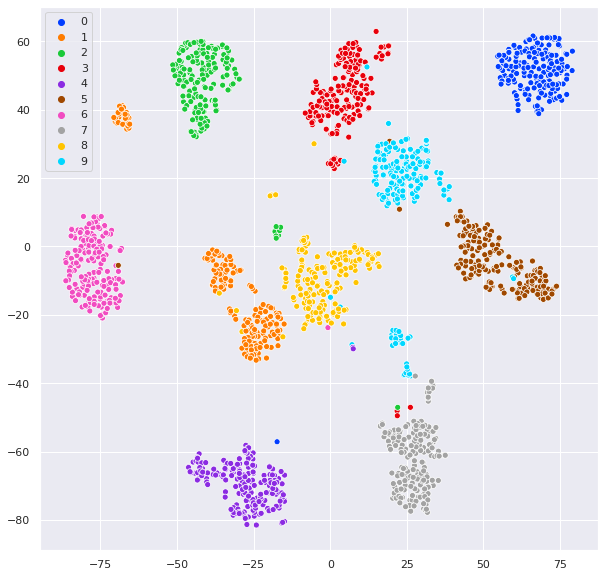

In [23]:
fig_dims = (10, 10)

fig, ax = plt.subplots(figsize=fig_dims)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette);

### Same thing using scikit

In [24]:
tsne = TSNE()
X_embedded = tsne.fit_transform(X)

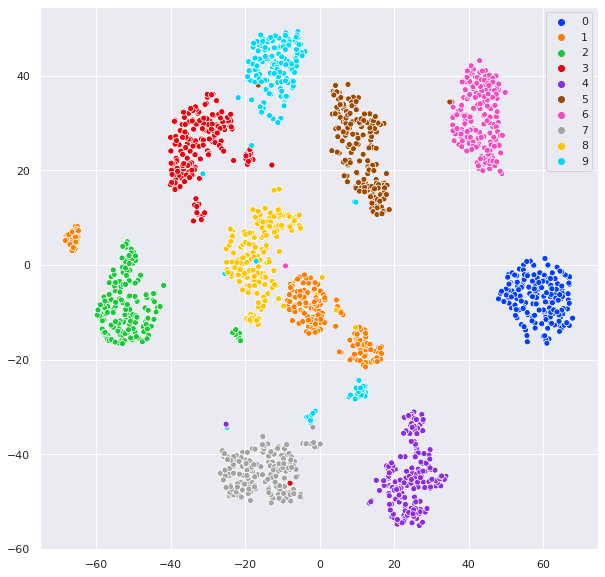

In [26]:

fig_dims = (10, 10)

fig, ax = plt.subplots(figsize=fig_dims)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette);